# Show, attend and tell

На основе [статьи](https://arxiv.org/pdf/1502.03044.pdf) и по мотивам [туториала](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning)

## Датасет

Использовать будем самый рапространённый датасет для задачи IC, а именно, MS COCO 2014. По ссылкам можно скачать [тренировочную](http://images.cocodataset.org/zips/train2014.zip) и [валидационную](http://images.cocodataset.org/zips/val2014.zip) выборки (сами картинки). Описания картинок можно скачать [здесь](http://cs.stanford.edu/people/karpathy/deepimagesent/caption_datasets.zip). Осторожно: архивы с картинками достаточно большие!

Для исследования и отладки кода и моделей ограничимся небольшим кусочком датасета. Но изначально его надо создать!

### Формат датасета

Загрузим json с подписями для картинок и попробуем разобраться, что там вообще лежит и что к чему:

In [1]:
import json

captions = {}
with open('/mnt/disks/disk1/COCO/dataset_coco.json') as f:
    captions = json.load(f)

Поисследуем структуру этого json'а. Можно было это сделать автоматически, но я не нашёл хорошей библиотеки, которая сгенерировала бы схему быстро и качественно. Поэтому, ручной труд:

In [2]:
print (captions.keys())
print (type(captions['dataset']))
print (captions['dataset'])
print (type(captions['images']))    
print (type(captions['images'][0]))

dict_keys(['images', 'dataset'])
<class 'str'>
coco
<class 'list'>
<class 'dict'>


In [3]:
image = captions['images'][0]
print (image.keys())
print (type(image['filepath']))
print (image['filepath'])
print (type(image['sentids']))
print (type(image['sentids'][0]))
print (image['sentids'][0])
print (type(image['filename']))
print (image['filename'])
print (type(image['imgid']))
print (image['imgid'])
print (type(image['split']))
print (image['split'])
print (type(image['sentences']))
print (type(image['sentences'][0]))
print (type(image['cocoid']))
print (image['cocoid'])

dict_keys(['filepath', 'sentids', 'filename', 'imgid', 'split', 'sentences', 'cocoid'])
<class 'str'>
val2014
<class 'list'>
<class 'int'>
770337
<class 'str'>
COCO_val2014_000000391895.jpg
<class 'int'>
0
<class 'str'>
test
<class 'list'>
<class 'dict'>
<class 'int'>
391895


In [4]:
sentence = image['sentences'][0]
print (sentence.keys())
print (type(sentence['tokens']))
print (type(sentence['tokens'][0]))
print (sentence['tokens'][0])
print (type(sentence['raw']))
print (sentence['raw'])
print (type(sentence['imgid']))
print (sentence['imgid'])
print (type(sentence['sentid']))
print (sentence['sentid'])

dict_keys(['tokens', 'raw', 'imgid', 'sentid'])
<class 'list'>
<class 'str'>
a
<class 'str'>
A man with a red helmet on a small moped on a dirt road. 
<class 'int'>
0
<class 'int'>
770337


In [5]:
for sentence in image['sentences']:
    print (sentence['raw'])

A man with a red helmet on a small moped on a dirt road. 
Man riding a motor bike on a dirt road on the countryside.
A man riding on the back of a motorcycle.
A dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud-wreathed mountains. 
A man in a red shirt and a red hat is on a motorcycle on a hill side.


In [ ]:
import nlpaug

Из исследований выше видно, что json представляет из себя следующую структуру:
```
{
    "dataset": строка с названием датасета,
    "images": список картинок,
}
```

Одна картинка имеет следующую схему:
```
{
    "filepath": имя папки с картинками,
    "sentids": список id подписей к картинке,
    "filename": имя файла внутри папки filepath,
    "imgid": id картинки,
    "split": к какому сплиту относится картинка,
    "sentences": список подписей к картинке,
    "cocoid": не очень понятно, что,
}
```

Одна подпись имеет схему:
```
{
    "raw": строка с самим описанием,
    "tokens": строка с описанием, разбитая на токены,
    "imgid": id картинки, к которой относится подпись,
    "sentid": id самой подписи,
}
```

### Создание мини-датасета

Теперь можно приступить и к созданию мини-датасета.

In [17]:
import os
import subprocess

In [20]:
!rm -rf /mnt/disks/disk1/mini_COCO
!mkdir /mnt/disks/disk1/mini_COCO
!mkdir /mnt/disks/disk1/mini_COCO/val2014
!mkdir /mnt/disks/disk1/mini_COCO/train2014

mini_dataset = {}
mini_dataset['dataset'] = 'mini_COCO'
mini_dataset['images'] = []

def modify_image(image):
    image_path = os.path.join('/mnt/disks/disk1/COCO', image['filepath'], image['filename'])
    new_image_path = os.path.join('/mnt/disks/disk1/mini_COCO', image['filepath'], image['filename'])
    subprocess.call(['cp', image_path, new_image_path])
    return image

train = 0
test = 0
val = 0
for image in captions['images']:
    if image['split'] in {'train'} and train < 5:
        train += 1
        mini_dataset['images'].append(modify_image(image))
    elif image['split'] == 'val' and val < 2:
        val += 1
        mini_dataset['images'].append(modify_image(image))
    elif image['split'] == 'test' and test < 2:
        test += 1
        mini_dataset['images'].append(modify_image(image))
        
with open('/mnt/disks/disk1/mini_COCO/dataset.json', 'w') as f:
    json.dump(mini_dataset, f)

### Визуализация датасета

In [6]:
%matplotlib inline
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

In [25]:
DATASET_PATH = '/mnt/disks/disk1/mini_COCO'

captions = {}
with open(os.path.join(DATASET_PATH, 'dataset.json')) as f:
    captions = json.load(f)

Напишем функцию, которая будет визуализировать картинку вместе с подписями к ней:

In [42]:
def show_image_with_captions(image):
    image_path = os.path.join(DATASET_PATH, image['filepath'], image['filename'])
    im = Image.open(image_path)
    plt.imshow(np.asarray(im))
    plt.title(image['split'])
    i = 0
    for sentence in image['sentences']:
        plt.annotate(sentence['raw'], (0,0), (0, -25 - 15 * i), xycoords='axes fraction', textcoords='offset points', va='top') 
        i += 1
    plt.show()

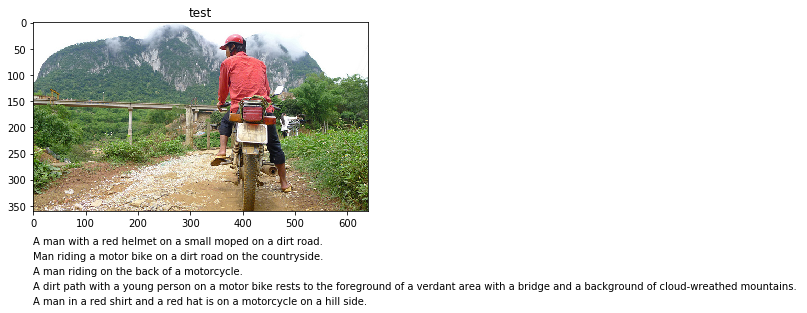

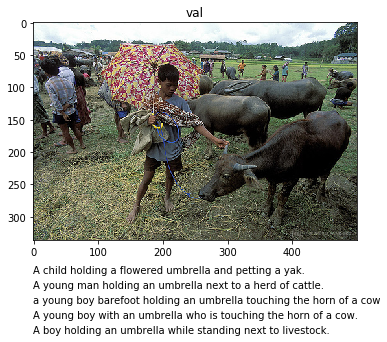

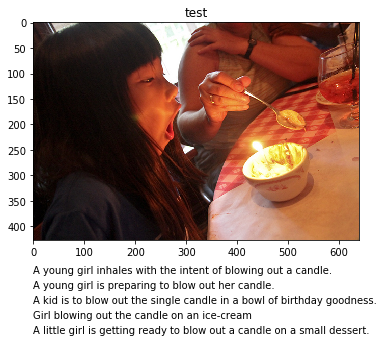

In [43]:
for image in captions['images'][:3]:
    show_image_with_captions(image)

### Создание датасета в формате .hdf5

Дело в том, что весь большой датасет COCO весит порядка 20 гигабайт. Конечно же, в память столько не загрузишь. Придётся читать картинки по частям, по мере того, как они нам будут нужны. Благо, необходимый формат был уже сделан за нас и называется HDF5. Для маленького датасета нам не очень актуально, но мы же на нём тренируемся работать!

Прочитать как работать с HDF5 в Python можно, например, [на хабре](https://habr.com/ru/company/otus/blog/416309/).

In [7]:
from collections import Counter
import h5py
from tqdm import tqdm_notebook as tqdm

Код взят непосредственно из туториала. Отличаются только несколько вещей:
* берутся все подписи, а не сколько-то случайных (для COCO их количество равно 5, на это ставится assert, при использовании других датасетов надо быть с этим осторожным)
* для работы с изображением вместо skimage используется pillow

In [78]:
def create_input_files(dataset, karpathy_json_path, image_folder, min_word_freq, output_folder,
                       max_len=100):
    """
    Creates input files for training, validation, and test data.
    :param dataset: name of dataset, one of 'coco', 'flickr8k', 'flickr30k'
    :param karpathy_json_path: path of Karpathy JSON file with splits and captions
    :param image_folder: folder with downloaded images
    :param min_word_freq: words occuring less frequently than this threshold are binned as <unk>s
    :param output_folder: folder to save files
    :param max_len: don't sample captions longer than this length
    """

    assert dataset in {'coco', 'flickr8k', 'flickr30k'}

    # Read Karpathy JSON
    with open(karpathy_json_path, 'r') as j:
        data = json.load(j)

    # Read image paths and captions for each image
    train_image_paths = []
    train_image_captions = []
    val_image_paths = []
    val_image_captions = []
    test_image_paths = []
    test_image_captions = []
    word_freq = Counter()

    for img in data['images']:
        captions = []
        for c in img['sentences']:
            # Update word frequency
            word_freq.update(c['tokens'])
            if len(c['tokens']) <= max_len:
                captions.append(c['tokens'])

        if len(captions) == 0:
            continue

        path = os.path.join(image_folder, img['filepath'], img['filename']) if dataset == 'coco' else os.path.join(
            image_folder, img['filename'])

        if img['split'] in {'train', 'restval'}:
            train_image_paths.append(path)
            train_image_captions.append(captions)
        elif img['split'] in {'val'}:
            val_image_paths.append(path)
            val_image_captions.append(captions)
        elif img['split'] in {'test'}:
            test_image_paths.append(path)
            test_image_captions.append(captions)

    # Sanity check
    assert len(train_image_paths) == len(train_image_captions)
    assert len(val_image_paths) == len(val_image_captions)
    assert len(test_image_paths) == len(test_image_captions)

    # Create word map
    words = [w for w in word_freq.keys() if word_freq[w] > min_word_freq]
    word_map = {k: v + 1 for v, k in enumerate(words)}
    word_map['<unk>'] = len(word_map) + 1
    word_map['<start>'] = len(word_map) + 1
    word_map['<end>'] = len(word_map) + 1
    word_map['<pad>'] = 0

    # Create a base/root name for all output files
    base_filename = dataset + '_' + str(min_word_freq) + '_min_word_freq'

    # Save word map to a JSON
    with open(os.path.join(output_folder, 'WORDMAP_' + base_filename + '.json'), 'w') as j:
        json.dump(word_map, j)

    # Sample captions for each image, save images to HDF5 file, and captions and their lengths to JSON files
    seed(123)
    for impaths, imcaps, split in [(train_image_paths, train_image_captions, 'TRAIN'),
                                   (val_image_paths, val_image_captions, 'VAL'),
                                   (test_image_paths, test_image_captions, 'TEST')]:

        with h5py.File(os.path.join(output_folder, split + '_IMAGES_' + base_filename + '.hdf5'), 'a') as h:
            # Make a note of the number of captions we are sampling per image
            h.attrs['captions_per_image'] = 5

            # Create dataset inside HDF5 file to store images
            images = h.create_dataset('images', (len(impaths), 3, 256, 256), dtype='uint8')

            print("\nReading %s images and captions, storing to file...\n" % split)

            enc_captions = []
            caplens = []

            for i, path in enumerate(tqdm(impaths)):
                # Sanity check
                assert len(captions) == 5

                # Read images
                img = Image.open(impaths[i])
                if len(np.asarray(img).shape) == 2:
                    img_arr = np.asarray(img)
                    img_arr = img_arr[:, :, np.newaxis]
                    img_arr = np.concatenate([img_arr, img_arr, img_arr], axis=2)
                    img = Image.fromarray(img_arr)
                img = img.resize((256, 256))
                image_array = np.asarray(img)
                image_array = image_array.transpose(2, 0, 1)
                assert image_array.shape == (3, 256, 256)
                assert np.max(image_array) <= 255

                # Save image to HDF5 file
                images[i] = image_array

                for j, c in enumerate(captions):
                    # Encode captions
                    enc_c = [word_map['<start>']] + [word_map.get(word, word_map['<unk>']) for word in c] + [
                        word_map['<end>']] + [word_map['<pad>']] * (max_len - len(c))

                    # Find caption lengths
                    c_len = len(c) + 2

                    enc_captions.append(enc_c)
                    caplens.append(c_len)

            # Save encoded captions and their lengths to JSON files
            with open(os.path.join(output_folder, split + '_CAPTIONS_' + base_filename + '.json'), 'w') as j:
                json.dump(enc_captions, j)

            with open(os.path.join(output_folder, split + '_CAPLENS_' + base_filename + '.json'), 'w') as j:
                json.dump(caplens, j)

Создадим hdf5 датасет из нашего чудесного мини-датасета:

In [86]:
create_input_files('coco', os.path.join(DATASET_PATH, 'dataset.json'), DATASET_PATH, 2, DATASET_PATH, 50)

Т.к. создание hdf5 датасета для всего COCO занимает немалое время, код ниже, на всякий случай, закомментирован:

In [19]:
ORIGINAL_DATASET_PATH = '/mnt/disks/disk1/COCO'

In [165]:
create_input_files('coco', os.path.join(ORIGINAL_DATASET_PATH, 'dataset_coco.json'), ORIGINAL_DATASET_PATH, 5, ORIGINAL_DATASET_PATH, 50)


Reading TRAIN images and captions, storing to file...





Reading VAL images and captions, storing to file...





Reading TEST images and captions, storing to file...



Но это ещё не всё! PyTorch работает со своим собственным типом датасета. Собственно, нам в качестве элемента хочется использовать картинку + одну подпись к ней (хотя, возможно, можно было бы использовать картинку со всеми подписями сразу). Что ж, сделаем по-пайторчевски:

In [8]:
from torch.utils.data import Dataset

class CaptionDataset(Dataset):
    """
    A PyTorch Dataset class to be used in a PyTorch DataLoader to create batches.
    """

    def __init__(self, data_folder, data_name, split, transform=None):
        """
        :param data_folder: folder where data files are stored
        :param data_name: base name of processed datasets
        :param split: split, one of 'TRAIN', 'VAL', or 'TEST'
        :param transform: image transform pipeline
        """
        self.split = split
        assert self.split in {'TRAIN', 'VAL', 'TEST'}

        # Open hdf5 file where images are stored
        self.h = h5py.File(os.path.join(data_folder, self.split + '_IMAGES_' + data_name + '.hdf5'), 'r')
        self.imgs = self.h['images']

        # Captions per image
        self.cpi = self.h.attrs['captions_per_image']

        # Load encoded captions (completely into memory)
        with open(os.path.join(data_folder, self.split + '_CAPTIONS_' + data_name + '.json'), 'r') as j:
            self.captions = json.load(j)

        # Load caption lengths (completely into memory)
        with open(os.path.join(data_folder, self.split + '_CAPLENS_' + data_name + '.json'), 'r') as j:
            self.caplens = json.load(j)

        # PyTorch transformation pipeline for the image (normalizing, etc.)
        self.transform = transform

        # Total number of datapoints
        self.dataset_size = len(self.captions)

    def __getitem__(self, i):
        # Remember, the Nth caption corresponds to the (N // captions_per_image)th image
        img = torch.FloatTensor(self.imgs[i // self.cpi] / 255.)
        if self.transform is not None:
            img = self.transform(img)

        caption = torch.LongTensor(self.captions[i])

        caplen = torch.LongTensor([self.caplens[i]])

        if self.split is 'TRAIN':
            return img, caption, caplen
        else:
            # For validation of testing, also return all 'captions_per_image' captions to find BLEU-4 score
            all_captions = torch.LongTensor(
                self.captions[((i // self.cpi) * self.cpi):(((i // self.cpi) * self.cpi) + self.cpi)])
            return img, caption, caplen, all_captions

    def __len__(self):
        return self.dataset_size

## Модели

Датасет создали, играем дальше. Теперь черёд создавать модели. Подробное теоретическое описание можно почитать в туториале или в оригинальной статье, мы же тут займёмся практикой.

In [9]:
import torch
from torch import nn
import torchvision

Хотелось бы всё обучать на GPU:

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Наша модель будет состоять из трёх частей: энкодера, аттеншена и декодера.

### Encoder

Собственно, имеем очень простой энкодер:
1. Отрываем последние слои у какой-нибудь предобученной сетки (по умолчанию у ResNet101). Имеем какое-то количество фичей-картинок;
2. К каждой применяем `Adaptive Average Pooling` для того, чтобы на вход можно было подавать картинки разного размера;
3. Всё, имеем конкретное количество фичей-картинок фиксированного размера. Всю работу за нас делает предобученная модель

Ещё момент. Можем делать fine tuning модели, если хочется. Для этого просто берём сколько-то последних (после отрывания настоящих последних) слоёв и обновляем там градиенты при обучении модели.

In [11]:
class Encoder(nn.Module):
    """
    Encoder.
    """

    def __init__(self, encoded_image_size=14):
        super(Encoder, self).__init__()
        self.enc_image_size = encoded_image_size

        resnet = torchvision.models.resnet101(pretrained=True)  # pretrained ImageNet ResNet-101

        # Remove linear and pool layers (since we're not doing classification)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        # Resize image to fixed size to allow input images of variable size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))

        self.fine_tune()

    def forward(self, images):
        """
        Forward propagation.
        :param images: images, a tensor of dimensions (batch_size, 3, image_size, image_size)
        :return: encoded images
        """
        out = self.resnet(images)  # (batch_size, 2048, image_size/32, image_size/32)
        out = self.adaptive_pool(out)  # (batch_size, 2048, encoded_image_size, encoded_image_size)
        out = out.permute(0, 2, 3, 1)  # (batch_size, encoded_image_size, encoded_image_size, 2048)
        return out

    def fine_tune(self, fine_tune=True):
        """
        Allow or prevent the computation of gradients for convolutional blocks 2 through 4 of the encoder.
        :param fine_tune: Allow?
        """
        for p in self.resnet.parameters():
            p.requires_grad = False
        # If fine-tuning, only fine-tune convolutional blocks 2 through 4
        for c in list(self.resnet.children())[5:]:
            for p in c.parameters():
                p.requires_grad = fine_tune

### Decoder

Что очень важно отметить. Хоть это и написано в туториале, стоит выделить, что для обучения модели используется teacher forcing. Дело в том, что в самом начале модели очень тяжело генерировать хоть что-то разумное. Поэтому если при генерации очередного токена подавать на вход слово, сгенерированное на предыдущем шаге, модель будет учиться очень медленно. Вместо этого при обучении на вход при очередной генерации мы подаём не сгенерированное слово, а слово из настоящей подписи.

Это же используется и при подсчёте метрик на валидации! Так что стоит быть осторожным и понимать, что это не до конца "честные" значения.

In [12]:
class DecoderWithAttention(nn.Module):
    """
    Decoder.
    """

    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim=2048, dropout=0.5):
        """
        :param attention_dim: size of attention network
        :param embed_dim: embedding size
        :param decoder_dim: size of decoder's RNN
        :param vocab_size: size of vocabulary
        :param encoder_dim: feature size of encoded images
        :param dropout: dropout
        """
        super(DecoderWithAttention, self).__init__()

        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout = dropout

        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)  # attention network

        self.embedding = nn.Embedding(vocab_size, embed_dim)  # embedding layer
        self.dropout = nn.Dropout(p=self.dropout)
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)  # decoding LSTMCell
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial hidden state of LSTMCell
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial cell state of LSTMCell
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)  # linear layer to create a sigmoid-activated gate
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)  # linear layer to find scores over vocabulary
        self.init_weights()  # initialize some layers with the uniform distribution

    def init_weights(self):
        """
        Initializes some parameters with values from the uniform distribution, for easier convergence.
        """
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def load_pretrained_embeddings(self, embeddings):
        """
        Loads embedding layer with pre-trained embeddings.
        :param embeddings: pre-trained embeddings
        """
        self.embedding.weight = nn.Parameter(embeddings)

    def fine_tune_embeddings(self, fine_tune=True):
        """
        Allow fine-tuning of embedding layer? (Only makes sense to not-allow if using pre-trained embeddings).
        :param fine_tune: Allow?
        """
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune

    def init_hidden_state(self, encoder_out):
        """
        Creates the initial hidden and cell states for the decoder's LSTM based on the encoded images.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :return: hidden state, cell state
        """
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        """
        Forward propagation.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, enc_image_size, enc_image_size, encoder_dim)
        :param encoded_captions: encoded captions, a tensor of dimension (batch_size, max_caption_length)
        :param caption_lengths: caption lengths, a tensor of dimension (batch_size, 1)
        :return: scores for vocabulary, sorted encoded captions, decode lengths, weights, sort indices
        """

        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size

        # Flatten image
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)

        # Sort input data by decreasing lengths; why? apparent below
        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]

        # Embedding
        embeddings = self.embedding(encoded_captions)  # (batch_size, max_caption_length, embed_dim)

        # Initialize LSTM state
        h, c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)

        # We won't decode at the <end> position, since we've finished generating as soon as we generate <end>
        # So, decoding lengths are actual lengths - 1
        decode_lengths = (caption_lengths - 1).tolist()

        # Create tensors to hold word predicion scores and alphas
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(device)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(device)

        # At each time-step, decode by
        # attention-weighing the encoder's output based on the decoder's previous hidden state output
        # then generate a new word in the decoder with the previous word and the attention weighted encoding
        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t],
                                                                h[:batch_size_t])
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))  # gating scalar, (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding
            h, c = self.decode_step(
                torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
                (h[:batch_size_t], c[:batch_size_t]))  # (batch_size_t, decoder_dim)
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha

        return predictions, encoded_captions, decode_lengths, alphas, sort_ind

### Attention

In [13]:
class Attention(nn.Module):
    """
    Attention Network.
    """

    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        """
        :param encoder_dim: feature size of encoded images
        :param decoder_dim: size of decoder's RNN
        :param attention_dim: size of the attention network
        """
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # linear layer to transform encoded image
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # linear layer to transform decoder's output
        self.full_att = nn.Linear(attention_dim, 1)  # linear layer to calculate values to be softmax-ed
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # softmax layer to calculate weights

    def forward(self, encoder_out, decoder_hidden):
        """
        Forward propagation.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :param decoder_hidden: previous decoder output, a tensor of dimension (batch_size, decoder_dim)
        :return: attention weighted encoding, weights
        """
        att1 = self.encoder_att(encoder_out)  # (batch_size, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden)  # (batch_size, attention_dim)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)  # (batch_size, num_pixels)
        alpha = self.softmax(att)  # (batch_size, num_pixels)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_dim)

        return attention_weighted_encoding, alpha

## Обучение моделей

Модели созданы, теперь можно и обучать!

In [34]:
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pack_padded_sequence
import time

In [35]:
DATASET_NAME = 'coco_5_min_word_freq'

# Model parameters
emb_dim = 512  # dimension of word embeddings
attention_dim = 512  # dimension of attention linear layers
decoder_dim = 512  # dimension of decoder RNN
dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # sets device for model and PyTorch tensors
cudnn.benchmark = True  # set to true only if inputs to model are fixed size; otherwise lot of computational overhead

encoder_lr = 1e-4  # learning rate for encoder if fine-tuning
decoder_lr = 4e-4  # learning rate for decoder
fine_tune_encoder = False  # fine-tune encoder?
batch_size = 32
workers = 1  # for data-loading; right now, only 1 works with h5py
start_epoch = 0
epochs = 120  # number of epochs to train for (if early stopping is not triggered)
epochs_since_improvement = 0  # keeps track of number of epochs since there's been an improvement in validation BLEU
alpha_c = 1.  # regularization parameter for 'doubly stochastic attention', as in the paper
print_freq = 10  # print training/validation stats every __ batches

In [36]:
# Read word map
word_map_file = os.path.join(ORIGINAL_DATASET_PATH, 'WORDMAP_' + DATASET_NAME + '.json')
with open(word_map_file, 'r') as j:
    word_map = json.load(j)

In [37]:
decoder = DecoderWithAttention(attention_dim=attention_dim,
                               embed_dim=emb_dim,
                               decoder_dim=decoder_dim,
                               vocab_size=len(word_map),
                               dropout=dropout)
decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),
                                     lr=decoder_lr)
encoder = Encoder()
encoder.fine_tune(fine_tune_encoder)
encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                     lr=encoder_lr) if fine_tune_encoder else None

In [38]:
# Move to GPU, if available
decoder = decoder.to(device)
encoder = encoder.to(device)

In [39]:
# Loss function
criterion = nn.CrossEntropyLoss().to(device)

In [40]:
# Custom dataloaders
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
train_loader = torch.utils.data.DataLoader(
    CaptionDataset(ORIGINAL_DATASET_PATH, DATASET_NAME, 'TRAIN', transform=transforms.Compose([normalize])),
    batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)
val_loader = torch.utils.data.DataLoader(
    CaptionDataset(ORIGINAL_DATASET_PATH, DATASET_NAME, 'VAL', transform=transforms.Compose([normalize])),
    batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)

In [41]:
class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [42]:
def accuracy(scores, targets, k):
    """
    Computes top-k accuracy, from predicted and true labels.
    :param scores: scores from the model
    :param targets: true labels
    :param k: k in top-k accuracy
    :return: top-k accuracy
    """

    batch_size = targets.size(0)
    _, ind = scores.topk(k, 1, True, True)
    correct = ind.eq(targets.view(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / batch_size)

In [43]:
def adjust_learning_rate(optimizer, shrink_factor):
    """
    Shrinks learning rate by a specified factor.
    :param optimizer: optimizer whose learning rate must be shrunk.
    :param shrink_factor: factor in interval (0, 1) to multiply learning rate with.
    """

    print("\nDECAYING learning rate.")
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr'] * shrink_factor
    print("The new learning rate is %f\n" % (optimizer.param_groups[0]['lr'],))

In [44]:
def validate(val_loader, encoder, decoder, criterion):
    """
    Performs one epoch's validation.
    :param val_loader: DataLoader for validation data.
    :param encoder: encoder model
    :param decoder: decoder model
    :param criterion: loss layer
    :return: BLEU-4 score
    """
    decoder.eval()  # eval mode (no dropout or batchnorm)
    if encoder is not None:
        encoder.eval()

    batch_time = AverageMeter()
    losses = AverageMeter()
    top5accs = AverageMeter()

    start = time.time()

    references = list()  # references (true captions) for calculating BLEU-4 score
    hypotheses = list()  # hypotheses (predictions)

    # explicitly disable gradient calculation to avoid CUDA memory error
    # solves the issue #57
    with torch.no_grad():
        # Batches
        for i, (imgs, caps, caplens, allcaps) in enumerate(val_loader):

            # Move to device, if available
            imgs = imgs.to(device)
            caps = caps.to(device)
            caplens = caplens.to(device)

            # Forward prop.
            if encoder is not None:
                imgs = encoder(imgs)
            scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

            # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
            targets = caps_sorted[:, 1:]

            # Remove timesteps that we didn't decode at, or are pads
            # pack_padded_sequence is an easy trick to do this
            scores_copy = scores.clone()
            scores, _ = pack_padded_sequence(scores, decode_lengths, batch_first=True)
            targets, _ = pack_padded_sequence(targets, decode_lengths, batch_first=True)

            # Calculate loss
            loss = criterion(scores, targets)

            # Add doubly stochastic attention regularization
            loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

            # Keep track of metrics
            losses.update(loss.item(), sum(decode_lengths))
            top5 = accuracy(scores, targets, 5)
            top5accs.update(top5, sum(decode_lengths))
            batch_time.update(time.time() - start)

            start = time.time()

            if i % print_freq == 0:
                print('Validation: [{0}/{1}]\t'
                      'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})\t'.format(i, len(val_loader), batch_time=batch_time,
                                                                                loss=losses, top5=top5accs))

            # Store references (true captions), and hypothesis (prediction) for each image
            # If for n images, we have n hypotheses, and references a, b, c... for each image, we need -
            # references = [[ref1a, ref1b, ref1c], [ref2a, ref2b], ...], hypotheses = [hyp1, hyp2, ...]

            # References
            allcaps = allcaps[sort_ind]  # because images were sorted in the decoder
            for j in range(allcaps.shape[0]):
                img_caps = allcaps[j].tolist()
                img_captions = list(
                    map(lambda c: [w for w in c if w not in {word_map['<start>'], word_map['<pad>']}],
                        img_caps))  # remove <start> and pads
                references.append(img_captions)

            # Hypotheses
            _, preds = torch.max(scores_copy, dim=2)
            preds = preds.tolist()
            temp_preds = list()
            for j, p in enumerate(preds):
                temp_preds.append(preds[j][:decode_lengths[j]])  # remove pads
            preds = temp_preds
            hypotheses.extend(preds)

            assert len(references) == len(hypotheses)

        # Calculate BLEU-4 scores
        bleu4 = corpus_bleu(references, hypotheses)

        print(
            '\n * LOSS - {loss.avg:.3f}, TOP-5 ACCURACY - {top5.avg:.3f}, BLEU-4 - {bleu}\n'.format(
                loss=losses,
                top5=top5accs,
                bleu=bleu4))

    return bleu4

In [45]:
def train(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, epoch):
    """
    Performs one epoch's training.
    :param train_loader: DataLoader for training data
    :param encoder: encoder model
    :param decoder: decoder model
    :param criterion: loss layer
    :param encoder_optimizer: optimizer to update encoder's weights (if fine-tuning)
    :param decoder_optimizer: optimizer to update decoder's weights
    :param epoch: epoch number
    """

    decoder.train()  # train mode (dropout and batchnorm is used)
    encoder.train()

    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
    losses = AverageMeter()  # loss (per word decoded)
    top5accs = AverageMeter()  # top5 accuracy

    start = time.time()

    # Batches
    for i, (imgs, caps, caplens) in enumerate(train_loader):
        data_time.update(time.time() - start)

        # Move to GPU, if available
        imgs = imgs.to(device)
        caps = caps.to(device)
        caplens = caplens.to(device)

        # Forward prop.
        imgs = encoder(imgs)
        scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

        # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
        targets = caps_sorted[:, 1:]

        # Remove timesteps that we didn't decode at, or are pads
        # pack_padded_sequence is an easy trick to do this
        scores = pack_padded_sequence(scores, decode_lengths, batch_first=True).data
        targets = pack_padded_sequence(targets, decode_lengths, batch_first=True).data

        # Calculate loss
        loss = criterion(scores, targets)

        # Add doubly stochastic attention regularization
        loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

        # Back prop.
        decoder_optimizer.zero_grad()
        if encoder_optimizer is not None:
            encoder_optimizer.zero_grad()
        loss.backward()

        # Clip gradients
        #if grad_clip is not None:
        #    clip_gradient(decoder_optimizer, grad_clip)
        #    if encoder_optimizer is not None:
        #        clip_gradient(encoder_optimizer, grad_clip)

        # Update weights
        decoder_optimizer.step()
        if encoder_optimizer is not None:
            encoder_optimizer.step()

        # Keep track of metrics
        top5 = accuracy(scores, targets, 5)
        losses.update(loss.item(), sum(decode_lengths))
        top5accs.update(top5, sum(decode_lengths))
        batch_time.update(time.time() - start)

        start = time.time()

        # Print status
        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data Load Time {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})'.format(epoch, i, len(train_loader),
                                                                          batch_time=batch_time,
                                                                          data_time=data_time, loss=losses,
                                                                          top5=top5accs))

In [ ]:
# Epochs
for epoch in range(start_epoch, epochs):

    # Decay learning rate if there is no improvement for 8 consecutive epochs, and terminate training after 20
    if epochs_since_improvement == 20:
        break
    if epochs_since_improvement > 0 and epochs_since_improvement % 8 == 0:
        adjust_learning_rate(decoder_optimizer, 0.8)
        if fine_tune_encoder:
            adjust_learning_rate(encoder_optimizer, 0.8)

    # One epoch's training
    train(train_loader=train_loader,
          encoder=encoder,
          decoder=decoder,
          criterion=criterion,
          encoder_optimizer=encoder_optimizer,
          decoder_optimizer=decoder_optimizer,
          epoch=epoch)

    # One epoch's validation
    recent_bleu4 = validate(val_loader=val_loader,
                            encoder=encoder,
                            decoder=decoder,
                            criterion=criterion)

    # Check if there was an improvement
    is_best = recent_bleu4 > best_bleu4
    best_bleu4 = max(recent_bleu4, best_bleu4)
    is_best = False
    if not is_best:
        epochs_since_improvement += 1
        print("\nEpochs since last improvement: %d\n" % (epochs_since_improvement,))
    else:
        epochs_since_improvement = 0

    # Save checkpoint
    #save_checkpoint(data_name, epoch, epochs_since_improvement, encoder, decoder, encoder_optimizer,
    #                decoder_optimizer, recent_bleu4, is_best)

Epoch: [0][0/17702]	Batch Time 1.986 (1.986)	Data Load Time 1.064 (1.064)	Loss 10.0391 (10.0391)	Top-5 Accuracy 0.000 (0.000)
Epoch: [0][10/17702]	Batch Time 0.815 (0.925)	Data Load Time 0.000 (0.097)	Loss 5.1029 (7.0234)	Top-5 Accuracy 57.647 (45.333)
Epoch: [0][20/17702]	Batch Time 0.803 (0.868)	Data Load Time 0.000 (0.051)	Loss 3.7752 (5.7545)	Top-5 Accuracy 65.538 (52.386)
Epoch: [0][30/17702]	Batch Time 0.791 (0.846)	Data Load Time 0.000 (0.035)	Loss 3.4837 (5.0781)	Top-5 Accuracy 68.060 (56.252)
Epoch: [0][40/17702]	Batch Time 0.816 (0.836)	Data Load Time 0.000 (0.026)	Loss 3.1931 (4.6397)	Top-5 Accuracy 75.595 (60.497)
Epoch: [0][50/17702]	Batch Time 0.813 (0.831)	Data Load Time 0.000 (0.021)	Loss 2.9062 (4.3236)	Top-5 Accuracy 83.036 (64.101)
Epoch: [0][60/17702]	Batch Time 0.823 (0.827)	Data Load Time 0.000 (0.018)	Loss 2.5352 (4.0581)	Top-5 Accuracy 91.445 (67.903)
Epoch: [0][70/17702]	Batch Time 0.823 (0.826)	Data Load Time 0.000 (0.015)	Loss 2.2131 (3.8255)	Top-5 Accuracy 9